# Proyecto Base de Datos

## Introducción
Este notebook tiene como propósito analizar los incendios forestales en cada estado del país desde el año 2020 hasta el 2023. En este proyecto, utilizaremos datos de la Comisión Nacional Forestal (CONAFOR) para examinar las áreas afectadas por estado, el tiempo promedio de respuesta y la duración de los incendios durante este periodo, así como los diferentes tipos de incendios.

### Carga y Exploración de Datos

In [110]:
import pymysql
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [111]:
db_name = "db_incendios_forestales"
db_host = "localhost"
db_username = "root"
db_password = "angel"

try:
    conn = pymysql.connect(host = db_host,
                           port = int(3306),
                           user = "root",
                           password = db_password,
                           db = db_name)
except e:
    print (e)
if conn:
    print ("connection successful")
else:
        print ("error")
        
data = pd.read_sql_query("SELECT * FROM db_incendios_forestales.`bd_incendiossnif_2015-2023`", conn)
data.head()

connection successful


C:\Users\betit\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Año,Clave_del_incendio,Latitud,Longitud,Clave_Municipio,Estado,Municipio,Región,Predio,Causa,Fecha_Inicio,Fecha_Termino,Tipo_de_incendio,Tipo_impacto,Total_hectáreas,Tamaño,Detección,Llegada,Duración
0,2020,20-02-0106,32.297464,-116.956542,5,Baja California,Playas de Rosarito,Noroeste,Playas de Rosarito / Ejido Plan Libertador - N...,Desconocidas,9/16/2020,9/21/2020,Superficial,Impacto Mínimo,5341.24,Mayor a 100 Hectáreas,12:12:00 AM,12:20:00 AM,119:52:00
1,2020,20-02-0013,32.243175,-116.911978,5,Baja California,Playas de Rosarito,Noroeste,Primo Tapia / Mar de Puerto Nuevo,Desconocidas,5/21/2020,5/21/2020,Superficial,Impacto Mínimo,4.59,0 a 5 Hectáreas,12:08:00 AM,12:12:00 AM,4:10:00
2,2020,20-02-0093,32.066789,-116.863689,1,Baja California,Ensenada,Noroeste,Ejido La Misión / La Salina,Actividades ilícitas,9/1/2020,9/2/2020,Superficial,Impacto Mínimo,90.60,51 a 100 Hectáreas,12:15:00 AM,12:45:00 AM,21:25:00
3,2020,20-02-0111,32.001925,-116.830089,1,Baja California,Ensenada,Noroeste,Jatay / Jatay,Fumadores,9/25/2020,9/25/2020,Superficial,Impacto Mínimo,1.79,0 a 5 Hectáreas,12:12:00 AM,12:18:00 AM,3:05:00
4,2020,20-02-0034,32.533081,-116.812919,4,Baja California,Tijuana,Noroeste,Ejido General Francisco Villa / El Niño,Desconocidas,6/9/2020,6/10/2020,Superficial,Impacto Mínimo,2069.96,Mayor a 100 Hectáreas,12:15:00 AM,12:30:00 AM,35:30:00


En este bloque de código, estamos importando las bibliotecas necesarias y cargando el conjunto de datos. Luego, mostramos las primeras filas del dataset para tener una vista previa de los datos.

### Limpieza y Preprocesamiento de Datos

Despues identificamos y manejamos los valores nulos, y convertimos las columnas categóricas en variables dummy.

### Análisis Exploratorio de Datos (EDA)

In [112]:
# Canvertir formato en fecha
data['Detección'] = pd.to_datetime(data['Detección'], errors='coerce')
data['Llegada'] = pd.to_datetime(data['Llegada'], errors='coerce')

# Convertir formato a horas
data['Duración'] = pd.to_timedelta(data['Duración'], errors='coerce').dt.total_seconds() / 3600

# Convertir hectareas en numero
data['Total_hectáreas'] = pd.to_numeric(data['Total_hectáreas'], errors='coerce')

# Convertir a horas
data['Duración'] = pd.to_numeric(data['Duración'], errors='coerce')

# Agrupar por estado
state_summary = data.groupby('Estado').agg(
    num_incidents=('Clave_del_incendio', 'count'),
    total_hectares=('Total_hectáreas', 'sum'),
    avg_duration=('Duración', 'mean')
).reset_index()

# Funcion para simplificar numero de hectareas
def simplify_number(num):
    if num >= 1e9:
        return f'{num/1e9:.2f}B'
    elif num >= 1e6:
        return f'{num/1e6:.2f}M'
    elif num >= 1e3:
        return f'{num/1e3:.2f}K'
    else:
        return f'{num:.2f}'

state_summary['total_hectares'] = state_summary['total_hectares'].apply(simplify_number)
state_summary

,Estado,num_incidents,total_hectares,avg_duration
0,Aguascalientes,136,5.16K,12.634804
1,Baja California,353,115.59K,33.114967
2,Baja California Sur,21,163.06,15.143651
3,Campeche,57,34.82K,104.553509
4,Chiapas,1375,171.31K,55.318303
5,Chihuahua,2159,229.87K,40.769870
6,Ciudad De México,737,2.10K,2.721574
7,Ciudad de México,2207,7.90K,3.046390
8,Coahuila,262,38.69K,74.244720
9,Colima,187,10.51K,36.835561


In [113]:
# Sacar info de Sonora
sonora_data = data[data['Estado'] == 'Sonora']

# Calcular infromacion de Sonora
sonora_summary = {
    'Num de incidents': sonora_data['Clave_del_incendio'].count(),
    'Hectares afectadas': sonora_data['Total_hectáreas'].sum(),
    'Duracion promedio': sonora_data['Duración'].mean(),
    'Tiempo de respuesta promedio': sonora_data['Llegada'].mean() - sonora_data['Detección'].mean()
}

# Calcular informacion nacional
national_summary = {
    'Num de incidents': data['Clave_del_incendio'].count(),
    'Hectares afectadas': data['Total_hectáreas'].sum(),
    'Duracion promedio': data['Duración'].mean(),
    'Tiempo de respuesta promedio': data['Llegada'].mean() - data['Detección'].mean()
}

# Crear un df para comparacion
comparison_summary = pd.DataFrame([sonora_summary, national_summary], index=['Sonora', 'National Average'])
comparison_summary

,Num de incidents,Hectares afectadas,Duracion promedio,Tiempo de respuesta promedio
Sonora,217,7.840074e+04,55.917358,0 days 03:00:08.294931200
National Average,27379,2.212747e+06,27.613384,0 days 01:28:56.844577792


In [114]:
# Funcion para encontrar la causa principal aparte de desconocidas
def most_common_and_next_common(causes):
    common_causes = causes.value_counts().index
    if common_causes[0] == 'Desconocidas' and len(common_causes) > 1:
        return common_causes[1]
    return common_causes[0]

# Agrupar por estado y aplicar funcion
most_common_cause_per_state = data.groupby('Estado')['Causa'].agg(most_common_and_next_common).reset_index()
most_common_cause_per_state

,Estado,Causa
0,Aguascalientes,Actividades ilícitas
1,Baja California,Quema de basureros
2,Baja California Sur,Quema de basureros
3,Campeche,Cazadores
4,Chiapas,Cazadores
5,Chihuahua,Actividades Agrícolas
6,Ciudad De México,Intencional
7,Ciudad de México,Actividades ilícitas
8,Coahuila,Naturales
9,Colima,Actividades agrícolas


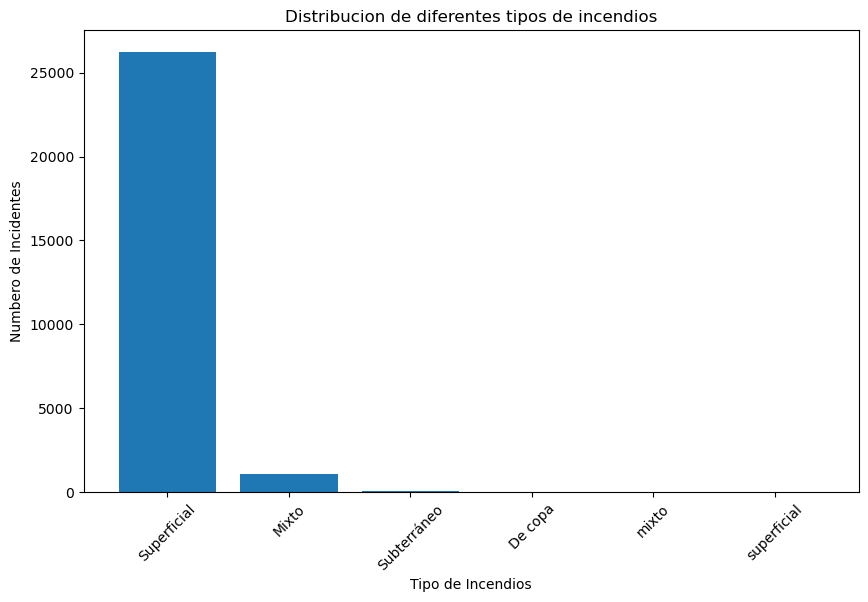

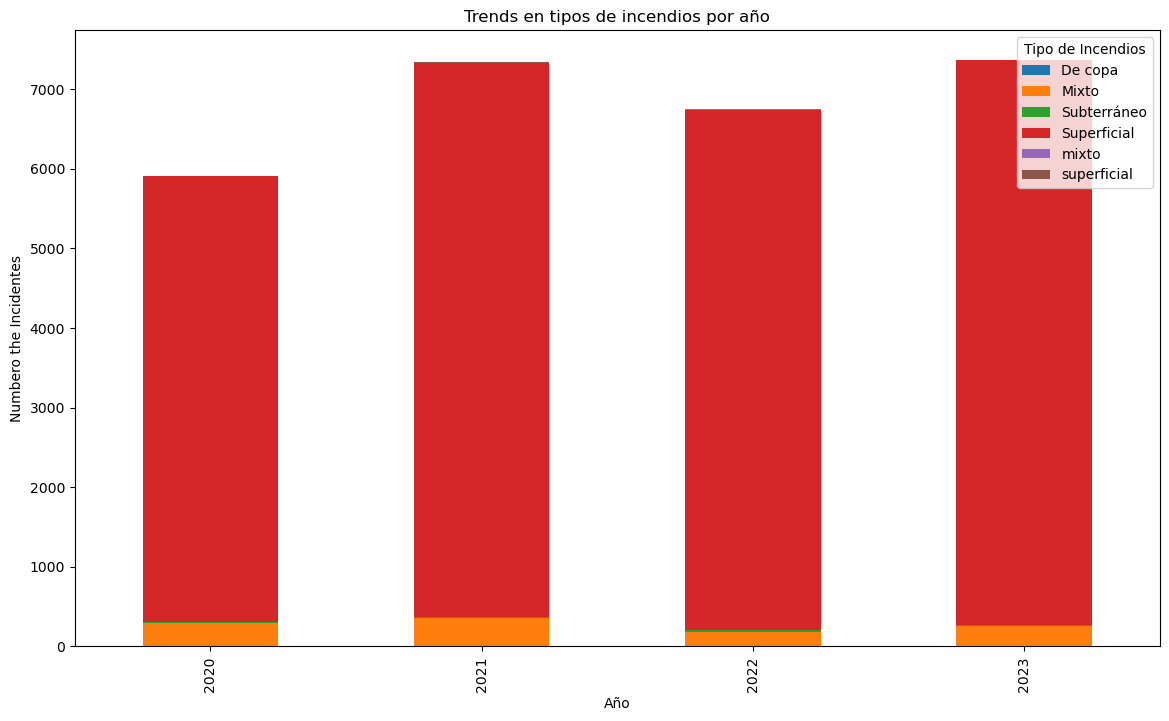

In [115]:
# Distribucion de tipos de incendios
fire_type_distribution = data['Tipo_de_incendio'].value_counts().reset_index()
fire_type_distribution.columns = ['Tipo_de_incendio', 'Conteo']

# Trends the incendios por años
fire_type_trends = data.groupby(['Año', 'Tipo_de_incendio']).size().unstack(fill_value=0)

# Plottear la distribucion
plt.figure(figsize=(10, 6))
plt.bar(fire_type_distribution['Tipo_de_incendio'], fire_type_distribution['Conteo'])
plt.xlabel('Tipo de Incendios')
plt.ylabel('Numbero de Incidentes')
plt.title('Distribucion de diferentes tipos de incendios')
plt.xticks(rotation=45)
plt.show()

# Plottear los tipos de incendios por año
fire_type_trends.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.xlabel('Año')
plt.ylabel('Numbero the Incidentes')
plt.title('Trends en tipos de incendios por año')
plt.legend(title='Tipo de Incendios')
plt.show()

## Conclusión y Trabajo Futuro

#### Distribución de Tipos de Incendios:
La mayoría de los incendios forestales registrados durante el período de estudio fueron de tipo "Superficial". Este tipo de incendio es el más común en casi todas las regiones, lo que sugiere que la mayoría de los incendios afectaron principalmente la superficie sin profundizar en el suelo ni en la copa de los árboles.

#### Tendencias de Incendios por Año:
A lo largo de los años, se observó una variación en la cantidad de incendios de cada tipo. Sin embargo, el tipo "Superficial" sigue siendo predominante año tras año. Este dato puede indicar la necesidad de focalizar las estrategias de prevención y control específicamente en este tipo de incendios.

#### Causas Comunes de Incendios:
Las causas de los incendios varían significativamente entre los estados. Sin embargo, en muchos estados, las actividades ilícitas y agrícolas son las principales causas. Es importante destacar que, en varios casos, cuando la causa más reportada es "Desconocidas", se consideró la siguiente causa más común para proporcionar una visión más clara.
Esta distribución de causas resalta la necesidad de abordar las actividades humanas como un factor crítico en la prevención de incendios forestales.

#### Impacto y Duración de los Incendios:
El análisis mostró que la duración promedio de los incendios varía considerablemente entre los estados. Algunos estados tienen incendios de corta duración, mientras que otros enfrentan incendios que duran más tiempo.
Las hectáreas afectadas también presentan grandes variaciones, con algunos estados reportando impactos significativos en términos de área quemada.

#### Estadísticas por Estado:
Algunos estados como Baja California y Chiapas presentan un alto número de incidentes y grandes áreas afectadas. Esto sugiere que estos estados podrían beneficiarse de una mayor atención y recursos para la prevención y el control de incendios.

### Referencias
información Incendios Forestales 2015 – 2023 de  https://datos.gob.mx/busca/dataset/incendios-forestales/resource/af7b6c08-47ba-4b43-8846-548a3f76c7e6 por CONAFOR Comisión Nacional Forestal